# The wormlike chain model

Requirements
+ matplotlib
+ numpy
+ scipy


<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb) -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Autoreload
# %load_ext autoreload
# %autoreload 2

# The wormlike chain model (Work in progress)

The wormlike chain model is a simple thermodynamic model of a polymer chain. It is commonly used to study the properties of DNA, proteins, and other biological macromolecules.


The energy of the wormlike chain is given by the sum of the inner products of adjacent bonds on the chain.

$$
    E = \kappa \sum_{i=1}^{N-1} (1 - \mathbf{t}_i \cdot \mathbf{t}_{i+1})
$$

We use the notation $\mathbb{T} \equiv \{\mathbf{t}_1, \mathbf{t}_2, \ldots, \mathbf{t}_N\}$ to represent the entire chain's configuration at a given time.


### Implementing the Wormlike chain model

We are now going to implement the wormlike chain model, and use Monte Carlo simulations to sample its equilibrium properties. Our implementation will first define a new object `Bond` that represents a unit-length tangent vector in 3D space. This object will essentially wrap a numpy array of shape (3,) with a unit norm. However, it will also provide a `rotate_in_place` method that rotates the vector in place by an arbitrary angle about an arbitrary axis. To do this, it implements [the Rodrigues rotation formula.](https://mathworld.wolfram.com/RodriguesRotationFormula.html)

Our `WormlikeChainMC` class will use an ordered list of `Bond` objects to represent the chain's unit tangent vectors. This is stored in the `bonds` attribute. The constructor initializes all of the bonds in the chain to be straight, with small random transverse displacements.

In order to map this problem onto a Monte Carlo algorithm, we need to (1) define a function that sweeps through the chain and attempts to rotate each bond about a random axis by a random angle, and (2) define a function that computes the chain's bending energy before and after the proposed move, and then performs a Metropolis acceptance test to determine whether to accept the proposed move.


1. Suppose you have two chains, $\mathbb{T}_1$ and $\mathbb{T}_2$, that differ only by a single bond $\mathbf{t}_i$. Calculate a minimal expression for the change in the energy $\Delta E$ between the two chains.

2. Using your result from (1), implement the `delta_energy` method in the `WormlikeChainMC` class.

3. Now, implement the `sweep` method. This method should attempt to rotate each bond about a random axis by a random angle, compute the change in energy, and then accept or reject the move using a Metropolis acceptance test.

There are two incomplete methods in the `WormlikeChainMC` class: `sweep` and `delta_energy`. Implement these methods.



Using the code below, compare the analytical and Monte Carlo results for the chain's end-to-end distance and tangent correlation function. What causes the discrepancies?




In [102]:
import numpy as np
from dataclasses import dataclass

def rand_unit_vec(rng: np.random.Generator) -> np.ndarray:
    """
    Args:
        rng (np.random.Generator): RNG.

    Returns:
        np.ndarray: Random unit vector on S^2 (shape (3,)).
    """
    z = rng.uniform(-1.0, 1.0)
    phi = rng.uniform(0.0, 2.0 * np.pi)
    r = np.sqrt(max(0.0, 1.0 - z * z))
    return np.array([r * np.cos(phi), r * np.sin(phi), z], dtype=float)


@dataclass
class Bond:
    """Unit-length bond/tangent vector in R^3 with in-place rotations.

    Parameters:
        v (np.ndarray): Initial vector (shape (3,)); will be normalized.

    Attributes:
        v (np.ndarray): Unit vector (shape (3,)).

    Methods:
        rotate_in_place(axis: np.ndarray, angle: float) -> None: Rotate about an 
            arbitrary axis by Rodrigues' formula; re-normalize.
        copy() -> "Bond": Return a copy of the Bond.
    """
    v: np.ndarray

    def __post_init__(self):
        self.set_vec(self.v)

    def set_vec(self, v: np.ndarray) -> None:
        """Assign vector and renormalize to unit length."""
        v = np.asarray(v, dtype=float).reshape(3)
        n = np.linalg.norm(v)
        if n == 0.0:
            raise ValueError("Zero vector is not allowed for Bond.")
        self.v = v / n

    def rotate_in_place(self, axis: np.ndarray, angle: float) -> None:
        """
        Given an arbitrary axis and angle, rotate the vector in place by Rodrigues' 
        formula, and then re-normalize.

        Args:
            axis (np.ndarray): Axis of rotation (shape (3,)).
            angle (float): Angle of rotation (radians).

        Returns:
            None
        """
        a = np.asarray(axis, dtype=float).reshape(3)
        na = np.linalg.norm(a)
        if na == 0.0:
            # Degenerate axis: no rotation
            return
        a /= na
        c, s = np.cos(angle), np.sin(angle)
        v = self.v
        # Rodrigues rotation
        v_rot = v * c + np.cross(a, v) * s + a * (np.dot(a, v)) * (1.0 - c)
        # Guard against FP drift
        self.v = v_rot / np.linalg.norm(v_rot)

    # Numpy interop: treat Bond like its vector
    def __array__(self, dtype=None):
        return np.asarray(self.v, dtype=dtype)

    def copy(self) -> "Bond":
        return Bond(self.v.copy())


class WormlikeChainMC:
    """Discrete 3D wormlike chain with Metropolis updates in tangent space.

    The chain is represented by N unit bond vectors (Bond objects) of fixed length b.
    Positions are reconstructed by r_{k+1} = r_k + b t_k (with r_0 at the origin).
    Bending energy: E = kappa * sum_i (1 - t_i · t_{i+1}).

    Parameters:
        N (int): Number of bonds.
        b (float): Bond length (segment length).
        kappa (float): Bending stiffness (k_B T units). Persistence length l_p = kappa * b.
        beta (float): Inverse temperature 1/T (k_B=1).
        seed (int | None): RNG seed.

    Attributes:
        N (int): Number of bonds.
        b (float): Bond length.
        kappa (float): Bending stiffness.
        beta (float): Inverse temperature.
        rng (np.random.Generator): RNG.
        bonds (list[Bond]): List of N Bond instances (unit vectors).
    """
    def __init__(self, N=400, b=1.0, kappa=20.0, beta=1.0, seed=None):
        self.N, self.b = int(N), float(b)
        self.kappa, self.beta = float(kappa), float(beta)
        self.rng = np.random.default_rng(seed)

        # start nearly straight with small transverse noise, then normalize per Bond
        base = np.tile(np.array([1.0, 0.0, 0.0], dtype=float), (self.N, 1))
        base += 0.05 * self.rng.normal(size=base.shape)
        self.bonds = [Bond(v) for v in base]

        ## calculate the persistence length
        self.lp = self.kappa * self.b

    # ---- helpers ----
    def _t_array(self) -> np.ndarray:
        """Stack current bond vectors as (N,3) ndarray (no copies of leaf arrays)."""
        return np.vstack([b.v for b in self.bonds])

    # @property
    def positions(self) -> np.ndarray:
        """Return positions r_k, k=0..N as shape (N+1,3) with r_0 = 0."""
        r = np.zeros((self.N + 1, 3), dtype=float)
        np.cumsum(self.b * self._t_array(), axis=0, out=r[1:])
        return r

    def energy(self) -> float:
        """Total bending energy."""
        t = self._t_array()
        dots = (t[:-1] * t[1:]).sum(axis=1)
        return float(self.kappa * np.sum(1.0 - dots))

    def _local_deltaE(self, i: int, trial_vec: np.ndarray) -> float:
        """Energy change from replacing t_i by trial_vec (only neighbors matter)."""
        dE = 0.0
        if i > 0:
            dE += self.kappa * ((1.0 - float(np.dot(trial_vec, self.bonds[i - 1].v)))
                                - (1.0 - float(np.dot(self.bonds[i].v, self.bonds[i - 1].v))))
        if i < self.N - 1:
            dE += self.kappa * ((1.0 - float(np.dot(trial_vec, self.bonds[i + 1].v)))
                                - (1.0 - float(np.dot(self.bonds[i].v, self.bonds[i + 1].v))))
        return float(dE)

    def sweep(self, step_size: float = 0.3) -> dict:
        """
        One Monte Carlo sweep consists of attempting N local rotations, one for each 
        bond on the chain.

        Args:
            step_size (float): Typical rotation angle (radians) for proposals.

        Returns:
            dict: {'acc': float, 'E': float} Whether the rotation was accepted and 
                the energy.
        """
        acc = 0
        for _ in range(self.N):
            i = int(self.rng.integers(self.N))  # choose a random bond
            axis = rand_unit_vec(self.rng)      # random axis
            angle = self.rng.normal(scale=step_size)

            # propose a rotated vector (without mutating)
            trial = self.bonds[i].copy()
            trial.rotate_in_place(axis, angle)
            t_new = trial.v  # guaranteed unit length

            dE = self._local_deltaE(i, t_new)
            if dE <= 0.0 or self.rng.random() < np.exp(-self.beta * dE):
                # accept: rotate in place (keeps unit length by construction)
                self.bonds[i].rotate_in_place(axis, angle)
                acc += 1
        return {"acc": acc / self.N, "E": self.energy()}

    def end_to_end(self):
        """Return end-to-end vector R and its squared length."""
        R = self.b * self._t_array().sum(axis=0)
        return R, float(np.dot(R, R))

    def tangent_correlation(self):
        """Compute C(s) = <t_i · t_{i+s}> averaged over i.

        Returns:
            (np.ndarray, np.ndarray): separations s, correlations C(s).
        """
        max_sep = (self.N - 1) // 4 # Largest separation is 1/4 of chain length
        s_vals = np.arange(0, max_sep + 1, dtype=int)
        t = self._t_array()
        C = np.zeros_like(s_vals, dtype=float)
        for si, s in enumerate(s_vals):
            dots = (t[: self.N - s] * t[s:]).sum(axis=1)
            C[si] = float(np.mean(dots))
        return s_vals, C
    

    def simulate(self, n_eq, step_size=0.25):
        """
        Simulate the wormlike chain and return self

        Args:
            n_eq (int): Number of of sweeps to equilibrate the chain.
            step_size (float): Proposal rotation angle scale (radians).
            seed (int): RNG seed.

        Returns:
            dict: {'E': np.ndarray, 'R2': np.ndarray, 'acc': np.ndarray, 't_corr': (s, C), 'chain': WormlikeChainMC}
        """
        for _ in range(n_eq):
            self.sweep(step_size=step_size)
        return self





### Test and visualize the wormlike chain

We can start by running a few sweeps to see that our code is working.



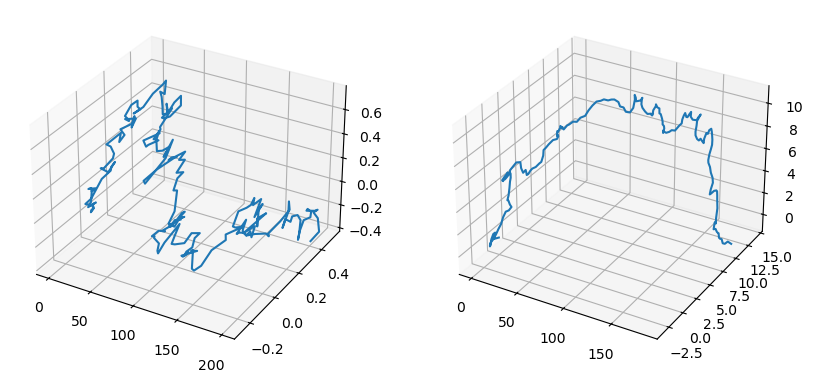

In [ ]:
mc = WormlikeChainMC(N=200, b=1.0, kappa=30.0, beta=0.5, seed=0)
positions_initial = mc.positions().copy()
mc.simulate(50)
positions_final = mc.positions().copy()


## side-by-side 3d subplots of the initial and final positions
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(positions_initial[:, 0], positions_initial[:, 1], positions_initial[:, 2])
ax2.plot(positions_final[:, 0], positions_final[:, 1], positions_final[:, 2])
plt.show()

We can also make a video of the chain by running sweeps in small batches, and storing the positions at each step.

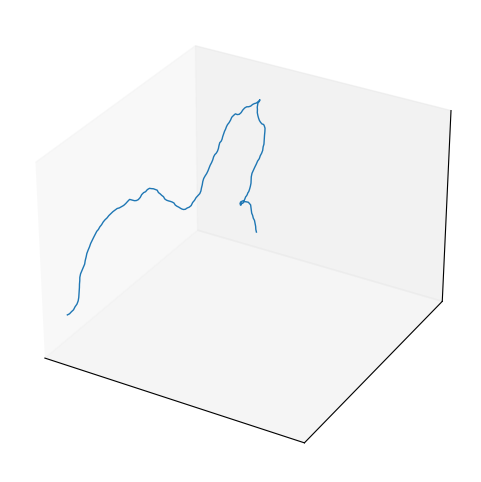

In [ ]:
## Run a few sweeps at a time to get a video of the chain
all_positions = []
mc = WormlikeChainMC(N=200, b=1.0, kappa=30.0, beta=0.5, seed=0)
for _ in range(300):
    mc.simulate(4)
    all_positions.append(mc.positions().copy())
all_positions = np.array(all_positions)




## Boilerplate code to make a video of the chain
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

frames = np.asarray(all_positions)  # (T, N, 3)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
(line,) = ax.plot([], [], [], lw=1)
def init():
    xyz = frames.reshape(-1, 3)
    ax.set_xlim(xyz[:, 0].min(), xyz[:, 0].max())
    ax.set_ylim(xyz[:, 1].min(), xyz[:, 1].max())
    ax.set_zlim(xyz[:, 2].min(), xyz[:, 2].max())
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    return (line,)
def update(i):
    """
    Args:
        i (int): Frame index.

    Returns:
        (tuple): Artists to redraw.
    """
    P = frames[i]  # (N, 3)
    line.set_data(P[:, 0], P[:, 1])
    line.set_3d_properties(P[:, 2])
    return (line,)
ani = FuncAnimation(fig, update, frames=len(frames), init_func=init, interval=50, blit=False)
HTML(ani.to_jshtml())

# from matplotlib.animation import FFMpegWriter
# Save to MP4 (requires ffmpeg installed and on PATH)
# ani.save("wormlike_chain_trajectory.mp4", writer=FFMpegWriter(fps=20))


In [54]:
all_tcorr = []
all_r2 = []
for seed in range(30):
    print(f"seed={seed}", flush=True)
    # out = demo_wlc(N=400, b=1.0, kappa=30.0, n_eq=500, n_meas=500, step_size=0.2, seed=seed, beta=0.1)

    mc = WormlikeChainMC(N=200, b=1.0, kappa=30.0, beta=0.5, seed=seed)
    mc.simulate(4000)
    all_tcorr.append(mc.tangent_correlation()[1])
    all_r2.append(mc.end_to_end()[1])
    # plt.plot(out["t_corr"][0], out["t_corr"][1], label=f"seed={seed}")
    # plt.plot(mc.tangent_correlation()[0], mc.tangent_correlation()[1], label=f"seed={seed}")

# plt.plot(np.exp(-out["t_corr"][0] / lp / 0.1))


seed=0
seed=1
seed=2
seed=3
seed=4
seed=5
seed=6
seed=7
seed=8
seed=9
seed=10
seed=11
seed=12
seed=13
seed=14
seed=15
seed=16
seed=17
seed=18
seed=19
seed=20
seed=21
seed=22
seed=23
seed=24
seed=25
seed=26
seed=27
seed=28
seed=29


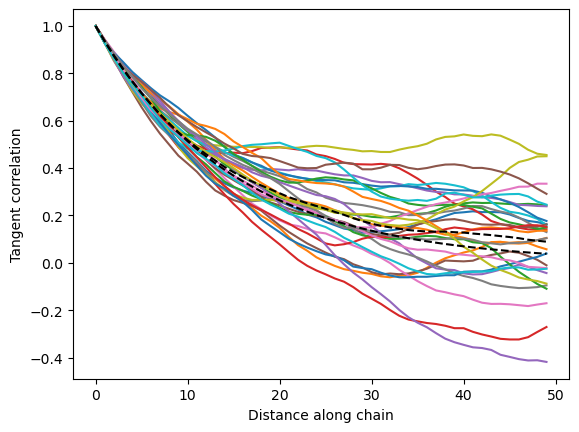

5550.000728818556
6513.1209848422895


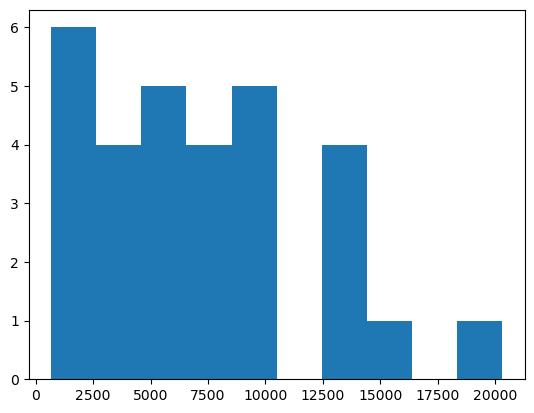

In [ ]:
## Plot the tangent correlation
plt.plot(np.array(all_tcorr).T)
scale = mc.tangent_correlation()[0]
plt.plot(np.mean(np.array(all_tcorr), axis=0), color="black", linestyle="--")
plt.plot(np.exp(-scale  / (mc.kappa * mc.b) / 0.5), color="black", linestyle="--")
plt.xlabel("Distance along chain")
plt.ylabel("Tangent correlation")
plt.show()


# Predicted end-to-end distance
lp = mc.lp * 0.5
L = mc.N * mc.b
R2_theory = 2 * lp * L * (1 - (lp / L) * (1 - np.exp(-L / lp)))
print(R2_theory)
print(np.median(np.array(all_r2)))
plt.hist(np.array(all_r2));

